In [ ]:
"""
Batch Size: 8
Beta 2: 0.8
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar=np.arange(noe*batch_number)/batch_number
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')
    
    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=8
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=0)

beta_1 = 0
beta_2 = 0.8

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
net.eval()

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB


C:\Users\Aria\AppData\Local\Temp\ipykernel_129400\595300361.py:158: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
Files already downloaded and verified


Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 2.106, Ça coûte 9.257
[1,  2000] loss: 1.725, Ça coûte 39.626
[1,  3000] loss: 1.623, Ça coûte 38.755
[1,  4000] loss: 1.623, Ça coûte 38.963
[1,  5000] loss: 1.598, Ça coûte 39.445
[1,  6000] loss: 1.586, Ça coûte 39.333
[2,  1000] loss: 1.578, Ça coûte 8.952
[2,  2000] loss: 1.603, Ça coûte 39.513
[2,  3000] loss: 1.589, Ça coûte 39.241
[2,  4000] loss: 1.643, Ça coûte 39.061
[2,  5000] loss: 1.573, Ça coûte 39.270
[2,  6000] loss: 1.597, Ça coûte 38.855
[3,  1000] loss: 1.537, Ça coûte 8.702
[3,  2000] loss: 1.489, Ça coûte 38.946
[3,  3000] loss: 1.494, Ça coûte 38.995
[3,  4000] loss: 1.523, Ça coûte 38.993
[3,  5000] loss: 1.524, Ça coûte 38.870
[3,  6000] loss: 1.524, Ça coûte 39.010
[4,  1000] loss: 1.467, Ça coûte 8.688
[4,  2000] loss: 1.558, Ça coûte 38.872
[4,  3000] loss: 1.467, Ça coûte 38.918
[4,  4000] loss: 1.484, Ça coûte 38.748
[4,  5000] loss: 1.469, Ça coûte 38.891
[4,  6000] loss: 1.541, Ça coûte 38.804
[5,  1000] loss: 1.383, Ça coûte 8.664
[5,  

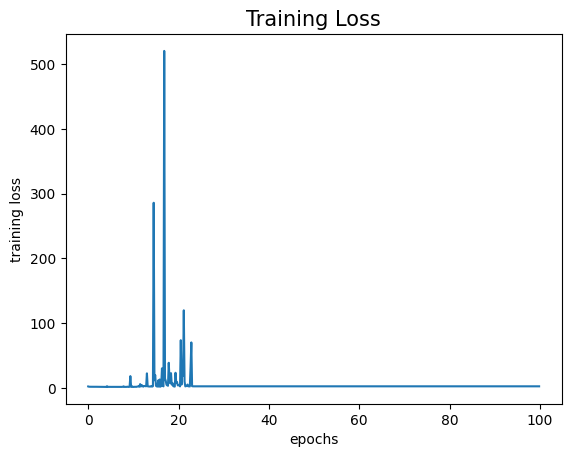

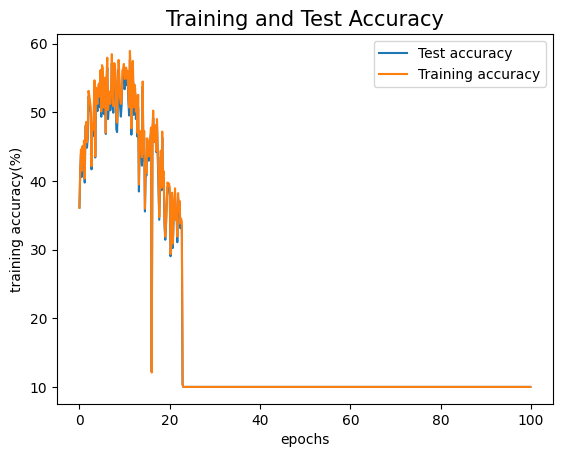

In [4]:
"""
Batch Size: 8
Beta 2: 0.9
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar=np.arange(noe*batch_number)/batch_number
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')
    
    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=8
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=0)

beta_1 = 0
beta_2 = 0.9

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
net.eval()

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB


C:\Users\Aria\AppData\Local\Temp\ipykernel_129400\683339048.py:162: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
Files already downloaded and verified


Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0
c:\Users\Aria\Desktop\CS536FinalProject\CS536_FinalProject\LocalRun\gpu_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Aria\Desktop\CS536FinalProject\CS536_FinalProject\LocalRun\gpu_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[1,  1000] loss: 2.151, Ça coûte 9.114
[1,  2000] loss: 1.712, Ça coûte 39.286
[1,  3000] loss: 1.597, Ça coûte 39.102
[1,  4000] loss: 1.520, Ça coûte 38.867
[1,  5000] loss: 1.478, Ça coûte 38.747
[1,  6000] loss: 1.456, Ça coûte 38.527
[2,  1000] loss: 1.390, Ça coûte 9.026
[2,  2000] loss: 1.382, Ça coûte 38.821
[2,  3000] loss: 1.390, Ça coûte 38.699
[2,  4000] loss: 1.408, Ça coûte 38.690
[2,  5000] loss: 1.380, Ça coûte 38.851
[2,  6000] loss: 1.393, Ça coûte 38.738
[3,  1000] loss: 1.247, Ça coûte 8.883
[3,  2000] loss: 1.247, Ça coûte 39.511
[3,  3000] loss: 1.552, Ça coûte 39.368
[3,  4000] loss: 1.294, Ça coûte 39.155
[3,  5000] loss: 1.390, Ça coûte 39.473
[3,  6000] loss: 1.325, Ça coûte 39.503
[4,  1000] loss: 1.227, Ça coûte 9.252
[4,  2000] loss: 1.197, Ça coûte 39.373
[4,  3000] loss: 1.791, Ça coûte 39.396
[4,  4000] loss: 1.281, Ça coûte 38.898
[4,  5000] loss: 1.269, Ça coûte 39.068
[4,  6000] loss: 1.258, Ça coûte 39.185
[5,  1000] loss: 1.167, Ça coûte 8.844
[5,  

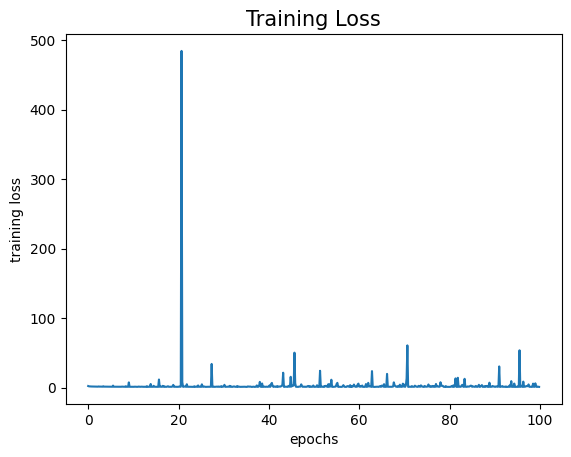

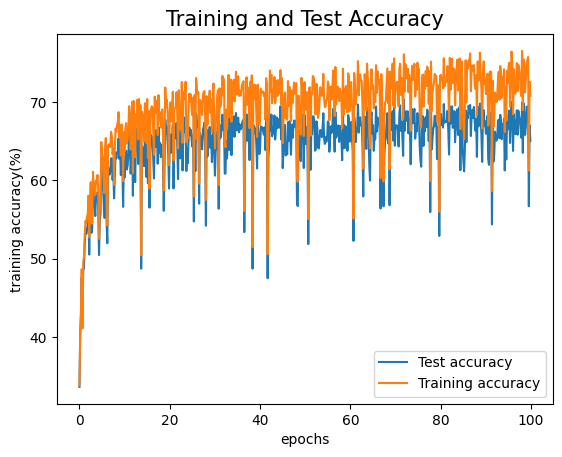

In [5]:
"""
Batch Size: 8
Beta 2: 0.95
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar=np.arange(noe*batch_number)/batch_number
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')
    
    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=8
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=0)

beta_1 = 0
beta_2 = 0.95

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
net.eval()

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB


C:\Users\Aria\AppData\Local\Temp\ipykernel_129400\670451029.py:162: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
Files already downloaded and verified


Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 2.175, Ça coûte 9.352
[1,  2000] loss: 1.734, Ça coûte 39.243
[1,  3000] loss: 1.548, Ça coûte 39.342
[1,  4000] loss: 1.460, Ça coûte 39.553
[1,  5000] loss: 1.431, Ça coûte 39.266
[1,  6000] loss: 1.367, Ça coûte 39.218
[2,  1000] loss: 1.295, Ça coûte 8.787
[2,  2000] loss: 1.270, Ça coûte 38.806
[2,  3000] loss: 1.280, Ça coûte 39.522
[2,  4000] loss: 1.206, Ça coûte 39.431
[2,  5000] loss: 1.194, Ça coûte 39.366
[2,  6000] loss: 1.202, Ça coûte 39.526
[3,  1000] loss: 1.052, Ça coûte 8.949
[3,  2000] loss: 1.020, Ça coûte 39.381
[3,  3000] loss: 1.052, Ça coûte 39.850
[3,  4000] loss: 1.039, Ça coûte 39.385
[3,  5000] loss: 1.039, Ça coûte 38.956
[3,  6000] loss: 1.005, Ça coûte 38.710
[4,  1000] loss: 0.906, Ça coûte 9.062
[4,  2000] loss: 0.850, Ça coûte 38.958
[4,  3000] loss: 0.875, Ça coûte 39.810
[4,  4000] loss: 0.915, Ça coûte 39.301
[4,  5000] loss: 0.920, Ça coûte 39.448
[4,  6000] loss: 0.909, Ça coûte 39.814
[5,  1000] loss: 0.756, Ça coûte 9.066
[5,  

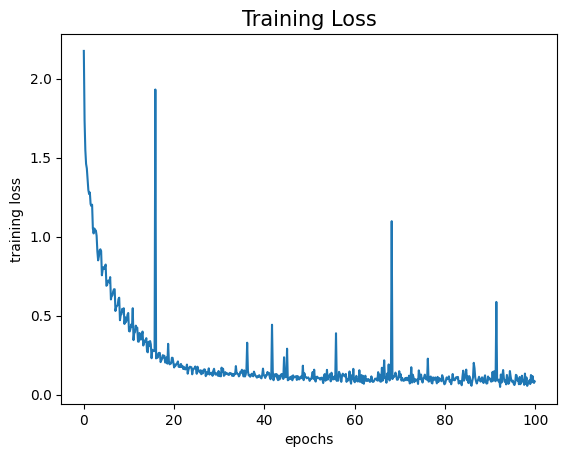

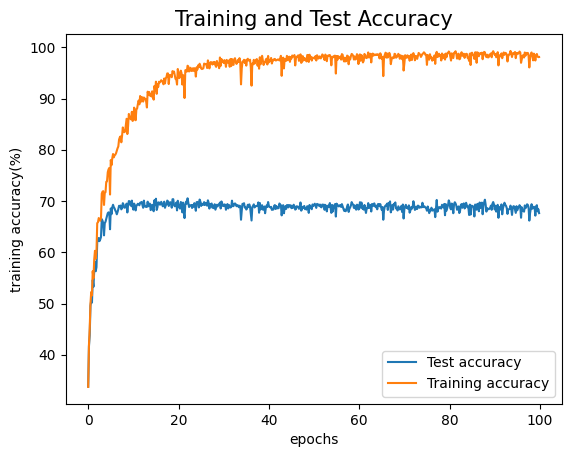

In [6]:
"""
Batch Size: 8
Beta 2: 0.99
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar=np.arange(noe*batch_number)/batch_number
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')
    
    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=8
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=0)

beta_1 = 0
beta_2 = 0.99

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
net.eval()

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB


C:\Users\Aria\AppData\Local\Temp\ipykernel_129400\3035697613.py:162: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
Files already downloaded and verified


Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.952, Ça coûte 10.545
[1,  2000] loss: 1.600, Ça coûte 31.142
[1,  3000] loss: 1.577, Ça coûte 30.897
[2,  1000] loss: 1.534, Ça coûte 10.268
[2,  2000] loss: 1.562, Ça coûte 31.090
[2,  3000] loss: 1.583, Ça coûte 31.737
[3,  1000] loss: 1.517, Ça coûte 10.302
[3,  2000] loss: 1.511, Ça coûte 31.269
[3,  3000] loss: 1.561, Ça coûte 31.207
[4,  1000] loss: 1.475, Ça coûte 10.292
[4,  2000] loss: 1.468, Ça coûte 31.166
[4,  3000] loss: 1.520, Ça coûte 31.151
[5,  1000] loss: 1.427, Ça coûte 10.299
[5,  2000] loss: 1.439, Ça coûte 31.133
[5,  3000] loss: 1.480, Ça coûte 31.300
[6,  1000] loss: 1.451, Ça coûte 10.336
[6,  2000] loss: 1.488, Ça coûte 31.251
[6,  3000] loss: 1.428, Ça coûte 30.988
[7,  1000] loss: 1.425, Ça coûte 10.377
[7,  2000] loss: 1.447, Ça coûte 31.207
[7,  3000] loss: 1.462, Ça coûte 31.186
[8,  1000] loss: 1.410, Ça coûte 10.349
[8,  2000] loss: 1.408, Ça coûte 31.220
[8,  3000] loss: 1.706, Ça coûte 31.284
[9,  1000] loss: 1.397, Ça coûte 10.295


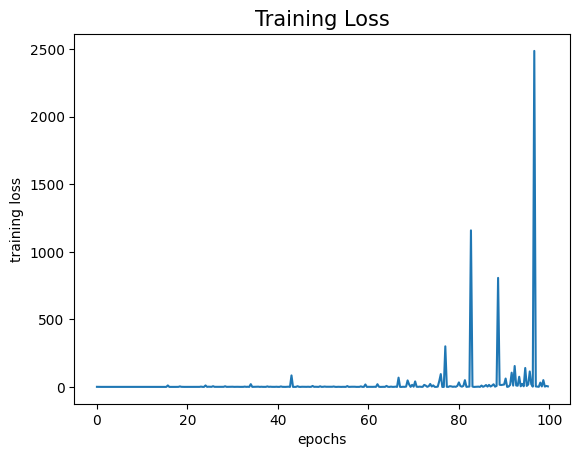

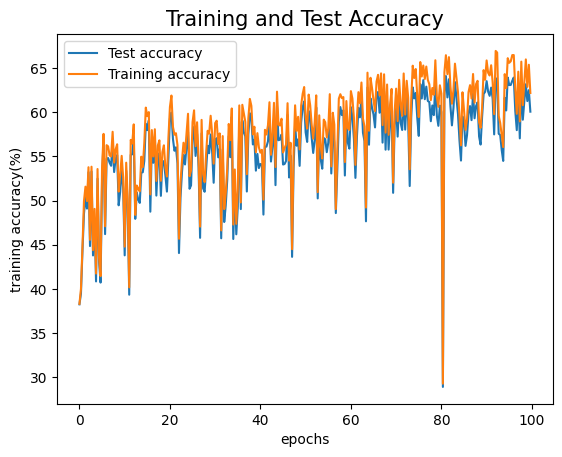

In [7]:
"""
Batch Size: 16
Beta 2: 0.8
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar=np.arange(noe*batch_number)/batch_number
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')
    
    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=16
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=0)

beta_1 = 0
beta_2 = 0.8

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
net.eval()

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB


C:\Users\Aria\AppData\Local\Temp\ipykernel_129400\1473486727.py:162: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
Files already downloaded and verified


Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.980, Ça coûte 10.406
[1,  2000] loss: 1.545, Ça coûte 31.040
[1,  3000] loss: 1.457, Ça coûte 31.207
[2,  1000] loss: 1.361, Ça coûte 10.330
[2,  2000] loss: 1.378, Ça coûte 31.259
[2,  3000] loss: 1.348, Ça coûte 31.138
[3,  1000] loss: 1.239, Ça coûte 10.329
[3,  2000] loss: 1.283, Ça coûte 31.146
[3,  3000] loss: 1.286, Ça coûte 31.081
[4,  1000] loss: 1.199, Ça coûte 10.264
[4,  2000] loss: 1.363, Ça coûte 31.186
[4,  3000] loss: 1.602, Ça coûte 31.215
[5,  1000] loss: 1.163, Ça coûte 10.260
[5,  2000] loss: 1.176, Ça coûte 31.208
[5,  3000] loss: 1.219, Ça coûte 31.618
[6,  1000] loss: 1.374, Ça coûte 10.365
[6,  2000] loss: 1.161, Ça coûte 30.869
[6,  3000] loss: 1.208, Ça coûte 31.436
[7,  1000] loss: 1.168, Ça coûte 10.294
[7,  2000] loss: 1.220, Ça coûte 30.954
[7,  3000] loss: 1.152, Ça coûte 31.015
[8,  1000] loss: 1.164, Ça coûte 10.377
[8,  2000] loss: 1.157, Ça coûte 30.875
[8,  3000] loss: 1.175, Ça coûte 30.972
[9,  1000] loss: 1.148, Ça coûte 10.215


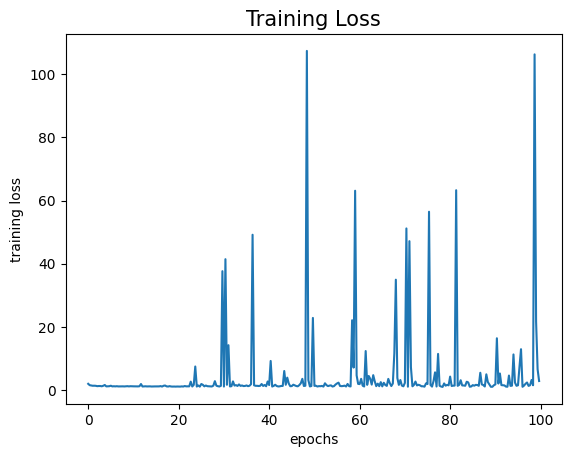

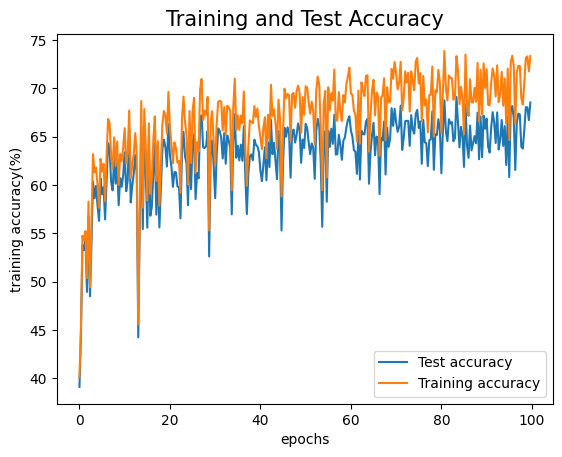

In [8]:
"""
Batch Size: 16
Beta 2: 0.9
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar=np.arange(noe*batch_number)/batch_number
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')
    
    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=16
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=0)

beta_1 = 0
beta_2 = 0.9

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
net.eval()

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB


C:\Users\Aria\AppData\Local\Temp\ipykernel_129400\2061152371.py:162: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
Files already downloaded and verified


Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.969, Ça coûte 10.404
[1,  2000] loss: 1.500, Ça coûte 30.235
[1,  3000] loss: 1.396, Ça coûte 30.333
[2,  1000] loss: 1.275, Ça coûte 10.190
[2,  2000] loss: 1.259, Ça coûte 30.266
[2,  3000] loss: 1.230, Ça coûte 30.295
[3,  1000] loss: 1.057, Ça coûte 10.219
[3,  2000] loss: 1.058, Ça coûte 30.030
[3,  3000] loss: 1.058, Ça coûte 30.304
[4,  1000] loss: 0.954, Ça coûte 10.265
[4,  2000] loss: 0.968, Ça coûte 30.275
[4,  3000] loss: 6.835, Ça coûte 30.037
[5,  1000] loss: 0.855, Ça coûte 10.205
[5,  2000] loss: 0.893, Ça coûte 30.272
[5,  3000] loss: 2.126, Ça coûte 30.235
[6,  1000] loss: 0.829, Ça coûte 10.210
[6,  2000] loss: 0.867, Ça coûte 30.343
[6,  3000] loss: 1.016, Ça coûte 30.340
[7,  1000] loss: 0.798, Ça coûte 10.271
[7,  2000] loss: 0.808, Ça coûte 30.294
[7,  3000] loss: 0.828, Ça coûte 30.316
[8,  1000] loss: 0.753, Ça coûte 10.279
[8,  2000] loss: 0.865, Ça coûte 30.208
[8,  3000] loss: 0.805, Ça coûte 30.311
[9,  1000] loss: 0.841, Ça coûte 10.214


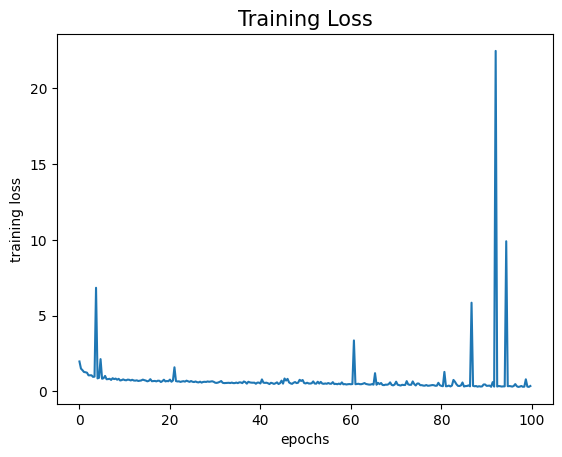

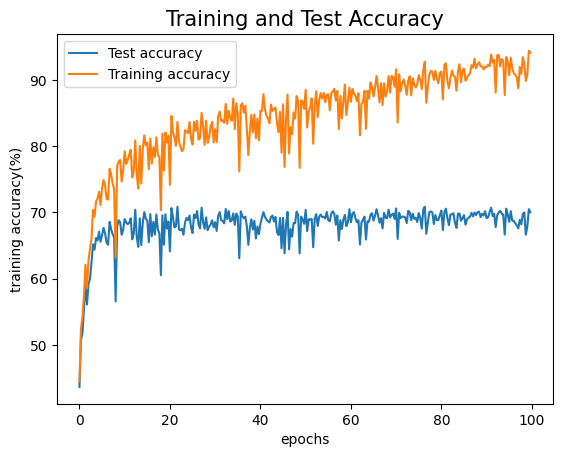

In [9]:
"""
Batch Size: 16
Beta 2: 0.95
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar=np.arange(noe*batch_number)/batch_number
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')
    
    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=16
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=0)

beta_1 = 0
beta_2 = 0.95

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
net.eval()

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB


C:\Users\Aria\AppData\Local\Temp\ipykernel_129400\1171275848.py:162: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
Files already downloaded and verified


Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 2.094, Ça coûte 10.319
[1,  2000] loss: 1.549, Ça coûte 30.347
[1,  3000] loss: 1.367, Ça coûte 30.350
[2,  1000] loss: 1.213, Ça coûte 10.318
[2,  2000] loss: 1.155, Ça coûte 30.315
[2,  3000] loss: 1.135, Ça coûte 30.385
[3,  1000] loss: 0.909, Ça coûte 10.278
[3,  2000] loss: 0.907, Ça coûte 30.106
[3,  3000] loss: 0.888, Ça coûte 30.335
[4,  1000] loss: 0.717, Ça coûte 10.250
[4,  2000] loss: 0.731, Ça coûte 30.387
[4,  3000] loss: 0.803, Ça coûte 30.182
[5,  1000] loss: 0.562, Ça coûte 10.260
[5,  2000] loss: 0.587, Ça coûte 30.220
[5,  3000] loss: 0.595, Ça coûte 30.268
[6,  1000] loss: 0.440, Ça coûte 10.190
[6,  2000] loss: 0.453, Ça coûte 30.197
[6,  3000] loss: 0.478, Ça coûte 30.310
[7,  1000] loss: 0.335, Ça coûte 10.187
[7,  2000] loss: 0.351, Ça coûte 30.265
[7,  3000] loss: 0.371, Ça coûte 30.213
[8,  1000] loss: 0.239, Ça coûte 10.233
[8,  2000] loss: 0.265, Ça coûte 30.160
[8,  3000] loss: 0.285, Ça coûte 30.357
[9,  1000] loss: 0.182, Ça coûte 10.242


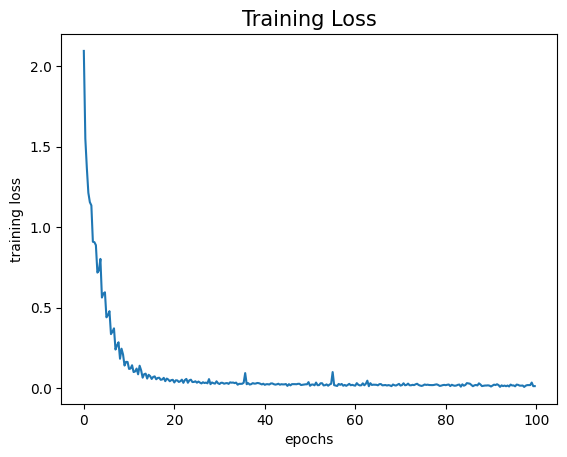

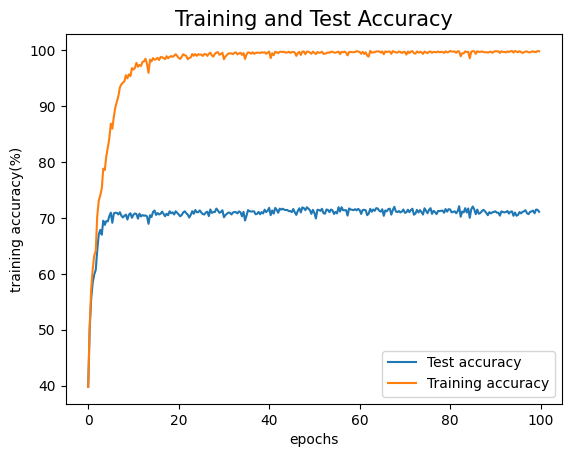

In [10]:
"""
Batch Size: 16
Beta 2: 0.99
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar=np.arange(noe*batch_number)/batch_number
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')
    
    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=16
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=0)

beta_1 = 0
beta_2 = 0.99

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
net.eval()

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB


C:\Users\Aria\AppData\Local\Temp\ipykernel_129400\2261703296.py:162: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
Files already downloaded and verified


Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.828, Ça coûte 13.294
[2,  1000] loss: 1.359, Ça coûte 13.444
[3,  1000] loss: 1.196, Ça coûte 13.138
[4,  1000] loss: 1.195, Ça coûte 13.509
[5,  1000] loss: 1.146, Ça coûte 13.042
[6,  1000] loss: 1.167, Ça coûte 12.887
[7,  1000] loss: 16.184, Ça coûte 13.350
[8,  1000] loss: 1.270, Ça coûte 13.788
[9,  1000] loss: 1.099, Ça coûte 13.394
[10,  1000] loss: 1.371, Ça coûte 13.160
[11,  1000] loss: 1.295, Ça coûte 12.948
[12,  1000] loss: 1.303, Ça coûte 13.137
[13,  1000] loss: 1.404, Ça coûte 13.118
[14,  1000] loss: 1.146, Ça coûte 13.099
[15,  1000] loss: 1.581, Ça coûte 13.355
[16,  1000] loss: 1.341, Ça coûte 13.221
[17,  1000] loss: 1.146, Ça coûte 13.289
[18,  1000] loss: 1.280, Ça coûte 13.414
[19,  1000] loss: 1.129, Ça coûte 13.304
[20,  1000] loss: 1.126, Ça coûte 13.474
[21,  1000] loss: 19.854, Ça coûte 13.091
[22,  1000] loss: 1.278, Ça coûte 13.491
[23,  1000] loss: 1.143, Ça coûte 13.502
[24,  1000] loss: 1.133, Ça coûte 13.544
[25,  1000] loss: 1.134

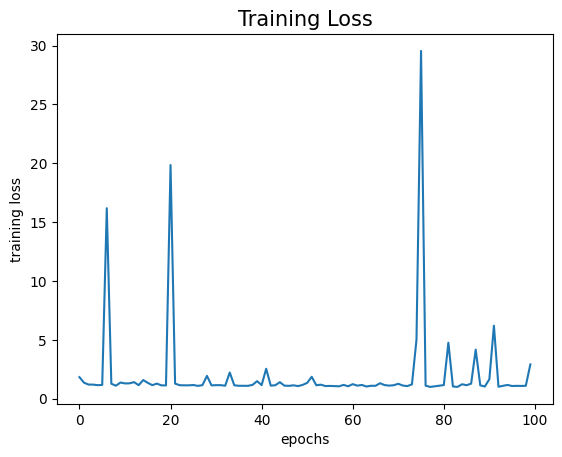

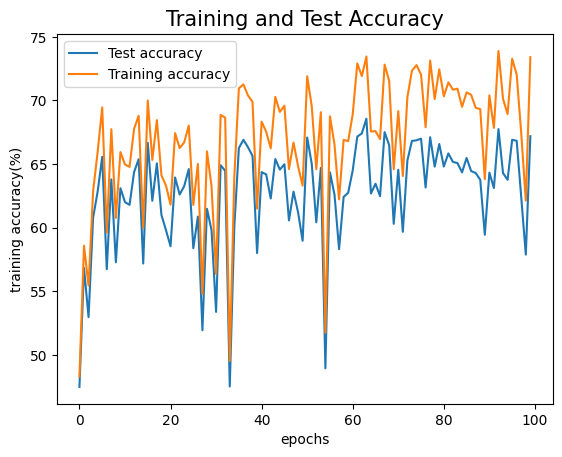

In [11]:
"""
Batch Size: 32
Beta 2: 0.8
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar=np.arange(noe*batch_number)/batch_number
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')
    
    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=32
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=0)

beta_1 = 0
beta_2 = 0.8

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
net.eval()

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB


C:\Users\Aria\AppData\Local\Temp\ipykernel_129400\3653205429.py:162: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
Files already downloaded and verified


Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.811, Ça coûte 13.549
[2,  1000] loss: 1.252, Ça coûte 13.260
[3,  1000] loss: 1.045, Ça coûte 13.307
[4,  1000] loss: 0.911, Ça coûte 13.293
[5,  1000] loss: 0.861, Ça coûte 13.310
[6,  1000] loss: 0.825, Ça coûte 13.252
[7,  1000] loss: 1.216, Ça coûte 13.085
[8,  1000] loss: 0.737, Ça coûte 13.212
[9,  1000] loss: 1.043, Ça coûte 13.224
[10,  1000] loss: 0.805, Ça coûte 13.256
[11,  1000] loss: 0.721, Ça coûte 13.280
[12,  1000] loss: 0.683, Ça coûte 13.240
[13,  1000] loss: 0.716, Ça coûte 13.329
[14,  1000] loss: 0.655, Ça coûte 13.322
[15,  1000] loss: 0.681, Ça coûte 13.316
[16,  1000] loss: 0.667, Ça coûte 13.276
[17,  1000] loss: 0.674, Ça coûte 13.147
[18,  1000] loss: 0.667, Ça coûte 13.302
[19,  1000] loss: 0.587, Ça coûte 13.326
[20,  1000] loss: 0.591, Ça coûte 13.257
[21,  1000] loss: 0.707, Ça coûte 13.288
[22,  1000] loss: 0.566, Ça coûte 13.243
[23,  1000] loss: 0.706, Ça coûte 13.228
[24,  1000] loss: 0.532, Ça coûte 13.233
[25,  1000] loss: 0.626, 

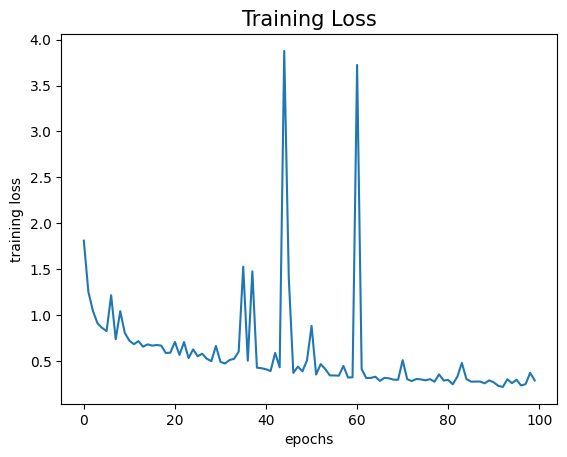

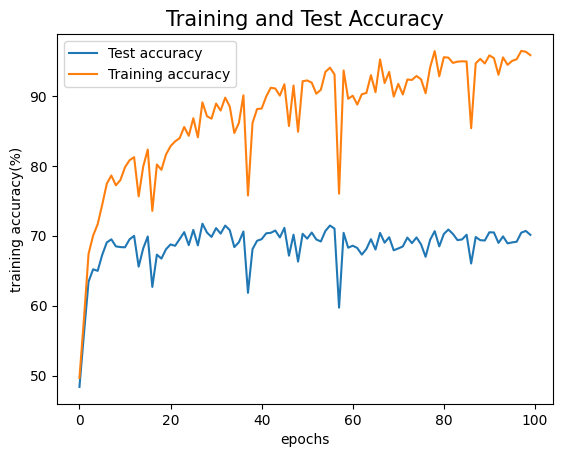

In [12]:
"""
Batch Size: 32
Beta 2: 0.9
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar=np.arange(noe*batch_number)/batch_number
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')
    
    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=32
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=0)

beta_1 = 0
beta_2 = 0.9

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
net.eval()

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB


C:\Users\Aria\AppData\Local\Temp\ipykernel_129400\3565843255.py:162: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
Files already downloaded and verified


Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.861, Ça coûte 13.556
[2,  1000] loss: 1.176, Ça coûte 13.251
[3,  1000] loss: 0.901, Ça coûte 13.200
[4,  1000] loss: 0.722, Ça coûte 13.277
[5,  1000] loss: 0.607, Ça coûte 13.205
[6,  1000] loss: 0.483, Ça coûte 13.249
[7,  1000] loss: 0.395, Ça coûte 13.218
[8,  1000] loss: 0.345, Ça coûte 13.245
[9,  1000] loss: 0.276, Ça coûte 13.213
[10,  1000] loss: 0.287, Ça coûte 13.109
[11,  1000] loss: 0.226, Ça coûte 13.234
[12,  1000] loss: 0.460, Ça coûte 13.225
[13,  1000] loss: 0.171, Ça coûte 13.203
[14,  1000] loss: 0.146, Ça coûte 13.252
[15,  1000] loss: 0.118, Ça coûte 13.273
[16,  1000] loss: 0.118, Ça coûte 13.279
[17,  1000] loss: 0.110, Ça coûte 13.315
[18,  1000] loss: 0.102, Ça coûte 13.231
[19,  1000] loss: 0.105, Ça coûte 13.240
[20,  1000] loss: 0.092, Ça coûte 13.114
[21,  1000] loss: 0.085, Ça coûte 13.234
[22,  1000] loss: 0.084, Ça coûte 13.245
[23,  1000] loss: 0.102, Ça coûte 13.147
[24,  1000] loss: 0.091, Ça coûte 13.172
[25,  1000] loss: 0.087, 

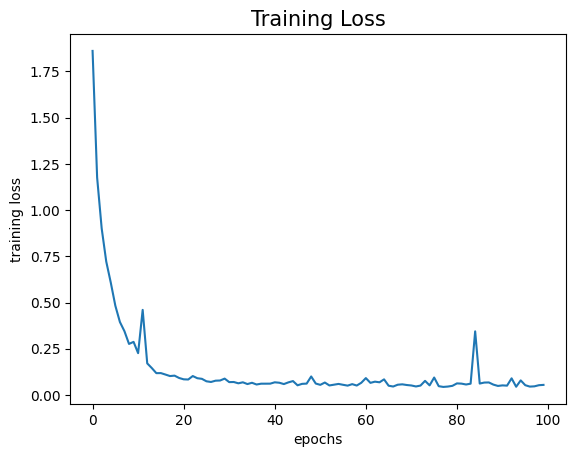

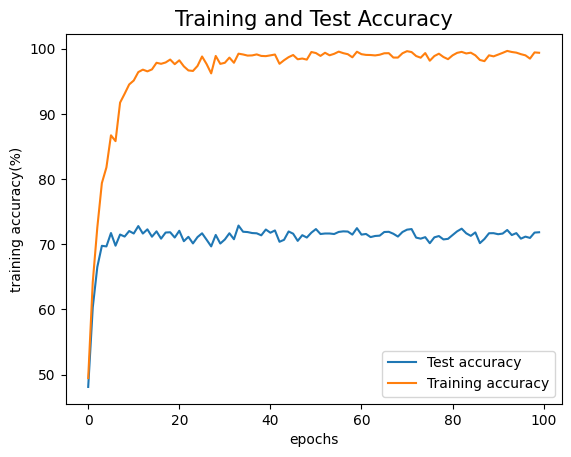

In [13]:
"""
Batch Size: 32
Beta 2: 0.95
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar=np.arange(noe*batch_number)/batch_number
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')
    
    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=32
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=0)

beta_1 = 0
beta_2 = 0.95

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
net.eval()

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finished Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB


C:\Users\Aria\AppData\Local\Temp\ipykernel_129400\2289785199.py:162: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Files already downloaded and verified
Files already downloaded and verified


Using cache found in C:\Users\Aria/.cache\torch\hub\pytorch_vision_v0.6.0


[1,  1000] loss: 1.862, Ça coûte 13.569
[2,  1000] loss: 1.198, Ça coûte 13.257
[3,  1000] loss: 0.894, Ça coûte 13.260
[4,  1000] loss: 0.676, Ça coûte 13.216
[5,  1000] loss: 0.493, Ça coûte 13.249
[6,  1000] loss: 0.341, Ça coûte 13.126
[7,  1000] loss: 0.235, Ça coûte 13.268
[8,  1000] loss: 0.168, Ça coûte 13.230
[9,  1000] loss: 0.124, Ça coûte 13.280
[10,  1000] loss: 0.090, Ça coûte 13.318
[11,  1000] loss: 0.080, Ça coûte 13.248
[12,  1000] loss: 0.068, Ça coûte 13.291
[13,  1000] loss: 0.058, Ça coûte 13.365
[14,  1000] loss: 0.051, Ça coûte 13.312
[15,  1000] loss: 0.042, Ça coûte 13.340
[16,  1000] loss: 0.038, Ça coûte 13.171
[17,  1000] loss: 0.035, Ça coûte 13.307
[18,  1000] loss: 0.036, Ça coûte 13.286
[19,  1000] loss: 0.038, Ça coûte 13.285
[20,  1000] loss: 0.034, Ça coûte 13.264
[21,  1000] loss: 0.027, Ça coûte 13.261
[22,  1000] loss: 0.033, Ça coûte 13.249
[23,  1000] loss: 0.022, Ça coûte 13.267
[24,  1000] loss: 0.022, Ça coûte 13.244
[25,  1000] loss: 0.023, 

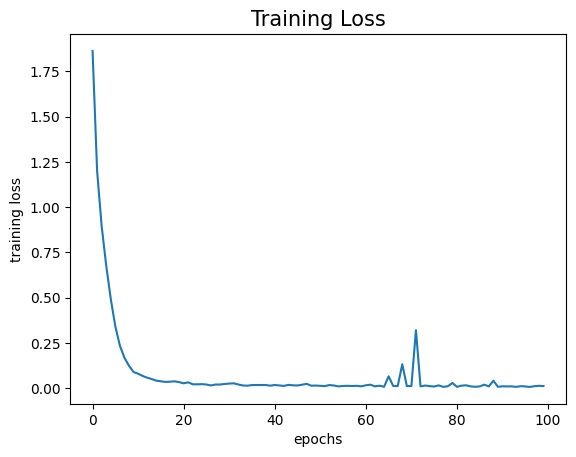

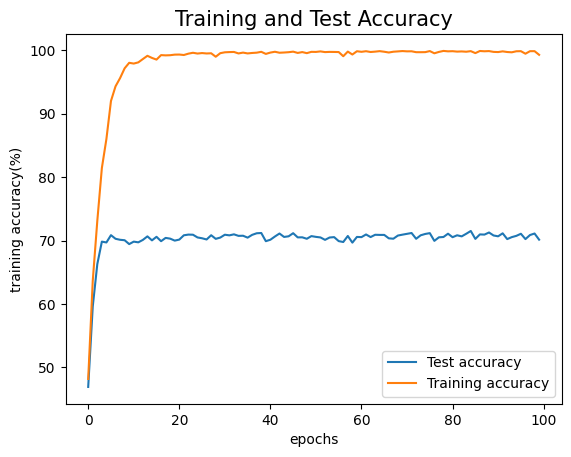

In [ ]:
"""
Batch Size: 32
Beta 2: 0.99
"""
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_some_pictures(j ):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(j)))


def random_test():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    net = Net()
    net.load_state_dict(torch.load(PATH))
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

def train(net, noe, filepath_trainloss, filepath_testacc, filepath_trainacc, initial_lr,  batchsize, device):
    doc = open(filepath_trainloss+'.txt', "w")
    doc2 = open(filepath_testacc+'.txt', "w")
    doc3 = open(filepath_trainacc+'.txt', "w")
    check_interval=1000
    batch_number = int(6000*8/(batchsize*check_interval))
    #print(batch_number)
    training_loss_vec = [] #np.zeros(noe*check_interval)
    train_acc_vec = [] #np.zeros(noe*check_interval)
    test_acc_vec = [] #np.zeros(noe*check_interval)
    for epoch in range(noe):  # loop over the dataset multiple times
        time_begin  = time.time()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % check_interval == (check_interval-1):    # print every 2000 mini-batches
                time_end = time.time()
                time_elapsed = time_end - time_begin
                time_begin = time.time()
                print('[%d, %5d] loss: %.3f, Ça coûte %.3f' %
                      (epoch + 1, i + 1, running_loss / check_interval, time_elapsed))
                training_loss_vec.append(running_loss/check_interval)
                train_acc = train_accuracy(net)
                train_acc_vec.append(train_acc)
                test_acc = test_accuracy(net)
                test_acc_vec.append(test_acc)
                print(running_loss / check_interval, file=doc)
                print(test_acc, file=doc2)
                print(train_acc, file=doc3)
                running_loss = 0.0
        if epoch % 1 == 0:
            for p in optimizer.param_groups:
                p['lr'] = initial_lr/np.sqrt(1+epoch)
    doc.close()
    doc2.close()

    xvar=np.arange(noe*batch_number)/batch_number
    #plt.subplot(122)
    plt.figure(1)
    plt.title("Training Loss", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training loss')
    plt.plot(xvar, np.array(training_loss_vec))
    plt.savefig(filepath_trainloss+'.png')

    #plt.subplot(122)
    plt.figure(2)
    plt.title("Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('test accuracy(%)')
    plt.plot(xvar, np.array(test_acc_vec), label="Test accuracy")
    plt.legend()
    plt.savefig(filepath_testacc + '.png')
    
    #plt.subplot(122)
    plt.figure(2)
    plt.title("Training and Test Accuracy", fontsize=15)
    plt.xlabel('epochs')
    plt.ylabel('training accuracy(%)')
    plt.plot(xvar, np.array(train_acc_vec), label="Training accuracy")
    plt.legend()
    plt.savefig(filepath_trainacc + '.png')

def train_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def test_accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

batchsize=32
# data sets
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                         shuffle=False, num_workers=0)

beta_1 = 0
beta_2 = 0.99

# resnet
net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
net.eval()

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(beta_1, beta_2), eps=1e-08, weight_decay=0, amsgrad=False)
train(net, 100, "Exp1-training-loss-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-test-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), "Exp1-train-accuracy-beta1="+str(beta_1)+";beta2="+str(beta_2)+";bs="+str(batchsize), 0.001, batchsize, device)
print('Finishegit d Training')
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
